# How to build a simple text classifier with TF-Hub

In [0]:
!pip install --upgrade tensorflow==1.7.0
!pip install -q tensorflow-hub

Requirement already up-to-date: tensorflow==1.7.0 in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow==1.7.0)
Requirement already up-to-date: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow==1.7.0)
Requirement already up-to-date: numpy>=1.13.3 in /usr/local/lib/python3.6/dist-packages (from tensorflow==1.7.0)
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow==1.7.0)
Requirement already up-to-date: absl-py>=0.1.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow==1.7.0)
Requirement already up-to-date: tensorboard<1.8.0,>=1.7.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow==1.7.0)
Requirement already up-to-date: gast>=0.2.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow==1.7.0)
Requirement already up-to-date: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow==

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

## Data

In [0]:
# Load all files from a directory in a DataFrame
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
      
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files

def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), "aclImdb", "test"))
  
  return train_df, test_df


In [0]:
# Reduce logging output
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,I think that people are under estimating this ...,10,1
1,This is one of those movies that's difficult t...,9,1
2,I loved the Batman tv series and was really lo...,2,0
3,"I found this movie boring, monotonous and quit...",3,0
4,Let me being by saying the I followed watching...,4,0


## Model

### Input functions

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
  train_df, train_df['polarity'], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
  train_df, train_df['polarity'], shuffle=False)

# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
  test_df, test_df['polarity'], shuffle=False)


### Feature columns

In [0]:
embedded_text_feature_column = hub.text_embedding_column(
  key="sentence",
  module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [0]:
embedded_text_feature_column

_TextEmbeddingColumn(key='sentence', module_spec=<tensorflow_hub.native_module._ModuleSpec object at 0x7f0d72f47dd8>, trainable=False)

### Estimator

In [0]:
estimator = tf.estimator.DNNClassifier(
  hidden_units=[500, 100],
  feature_columns=[embedded_text_feature_column],
  n_classes=2,
  optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### Training

In [0]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000)

# Prediction

In [0]:
# Run the prediction for both training and test set
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8013200163841248
Test set accuracy: 0.7936800122261047


In [0]:
keys(train_eval_result)

NameError: ignored

# Confusion matrix

Text(51,0.5,'True')

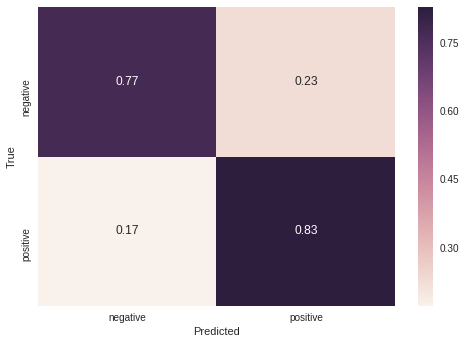

In [0]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]


LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data

with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"],
                           get_predictions(estimator, predict_train_input_fn))
  
  with tf.Session() as session:
    cm_out = session.run(cm)
    

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

# Advanced: Transfer learning analysis

In [0]:
def train_and_evaluate_with_module(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
    key="sentence",
    module_spec=hub_module,
    trainable=train_module)
  
  estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))
  
  estimator.train(input_fn=train_input_fn, steps=1000)
  
  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
  
  training_set_accuracy = train_eval_result['accuracy']
  test_set_accuracy = test_eval_result['accuracy']
  
  return {
    "Training accuracy": training_set_accuracy,
    "Test accuracy": test_set_accuracy
  }


results = {}
results['nnlm-en_dim128'] = train_and_evaluate_with_module(
  "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

In [0]:
pd.DataFrame.from_dict(results, orient="index")